In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

In [76]:
reg_results = pd.read_csv("MRegularSeasonCompactResults.csv")

In [77]:
reg_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [78]:
reg_results['Score_Diff'] = reg_results['WScore'] - reg_results['LScore']

In [79]:
reg_results.drop(['WLoc','NumOT'],axis=1, inplace=True)

In [80]:
num_win = reg_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [81]:
num_win

,Season,TeamID,NumWins
0,1985,1102,5
1,1985,1103,9
2,1985,1104,21
3,1985,1106,10
4,1985,1108,19
...,...,...,...
11575,2020,1463,21
11576,2020,1464,16
11577,2020,1465,17
11578,2020,1466,11


In [82]:
num_loss = reg_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [83]:
num_loss

,Season,TeamID,NumLosses
0,1985,1102,19
1,1985,1103,14
2,1985,1104,9
3,1985,1106,14
4,1985,1108,6
...,...,...,...
11586,2020,1463,7
11587,2020,1464,15
11588,2020,1465,10
11589,2020,1466,17


In [84]:
scoring_win = reg_results.groupby(['Season', 'WTeamID']).mean().reset_index()
scoring_win = scoring_win[['Season','WTeamID','Score_Diff']].rename(columns={'WTeamID':'TeamID','Score_Diff':'Win_Score_Diff'})

In [85]:
scoring_win.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11580 entries, 0 to 11579
Data columns (total 3 columns):
Season            11580 non-null int64
TeamID            11580 non-null int64
Win_Score_Diff    11580 non-null float64
dtypes: float64(1), int64(2)
memory usage: 271.5 KB


In [86]:
scoring_loss = reg_results.groupby(['Season', 'LTeamID']).mean().reset_index()
scoring_loss = scoring_loss[['Season','LTeamID','Score_Diff']].rename(columns={'LTeamID':'TeamID','Score_Diff':'Loss_Score_Diff'})

In [87]:
scoring_loss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11591 entries, 0 to 11590
Data columns (total 3 columns):
Season             11591 non-null int64
TeamID             11591 non-null int64
Loss_Score_Diff    11591 non-null float64
dtypes: float64(1), int64(2)
memory usage: 271.8 KB


In [88]:
df_features_season_w = reg_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = reg_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [89]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)
df_features_season

,Season,TeamID
0,1985,1102
1,1985,1103
2,1985,1104
3,1985,1106
4,1985,1108
...,...,...
11589,2020,1463
11590,2020,1464
11591,2020,1465
11592,2020,1466


In [90]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(scoring_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(scoring_loss, on=['Season', 'TeamID'], how='left')

In [91]:
df_features_season.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11594 entries, 0 to 11593
Data columns (total 6 columns):
Season             11594 non-null int64
TeamID             11594 non-null int64
NumWins            11580 non-null float64
NumLosses          11591 non-null float64
Win_Score_Diff     11580 non-null float64
Loss_Score_Diff    11591 non-null float64
dtypes: float64(4), int64(2)
memory usage: 634.0 KB


In [92]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['Win_Score_Diff'] - 
    df_features_season['NumLosses'] * df_features_season['Loss_Score_Diff'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [93]:
df_features_season

,Season,TeamID,NumWins,NumLosses,Win_Score_Diff,Loss_Score_Diff,WinRatio,GapAvg
0,1985,1102,5.0,19.0,10.000000,9.947368,0.208333,-5.791667
1,1985,1103,9.0,14.0,7.555556,9.857143,0.391304,-3.043478
2,1985,1104,21.0,9.0,13.190476,4.777778,0.700000,7.800000
3,1985,1106,10.0,14.0,9.500000,13.285714,0.416667,-3.791667
4,1985,1108,19.0,6.0,13.842105,10.666667,0.760000,7.960000
...,...,...,...,...,...,...,...,...
11589,2020,1463,21.0,7.0,12.761905,5.714286,0.750000,8.142857
11590,2020,1464,16.0,15.0,8.562500,10.733333,0.516129,-0.774194
11591,2020,1465,17.0,10.0,14.176471,11.500000,0.629630,4.666667
11592,2020,1466,11.0,17.0,10.636364,12.117647,0.392857,-3.178571


In [94]:
df_features_season.fillna(0, inplace=True)

In [95]:
tourney_results = pd.read_csv("MNCAATourneyCompactResults.csv")

In [96]:
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2246,2019,146,1120,77,1246,71,N,1
2247,2019,146,1277,68,1181,67,N,0
2248,2019,152,1403,61,1277,51,N,0
2249,2019,152,1438,63,1120,62,N,0


In [97]:
df = tourney_results.copy()
df = df[df['Season'] >= 2003].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,2003,134,1421,92,1411,84,N,1
1,2003,136,1112,80,1436,51,N,0
2,2003,136,1113,84,1272,71,N,0
3,2003,136,1141,79,1166,73,N,0
4,2003,136,1143,76,1301,74,N,1


In [98]:
seeds = pd.read_csv("MNCAATourneySeeds.csv")

In [99]:
#seeds = seeds.merge(teams,on='TeamID')

In [100]:
#seeds[seeds['Season']==2019]

In [101]:
seeds['Seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

In [102]:
seeds

,Season,Seed,TeamID
0,1985,1,1207
1,1985,2,1210
2,1985,3,1228
3,1985,4,1260
4,1985,5,1374
...,...,...,...
2281,2019,12,1332
2282,2019,13,1414
2283,2019,14,1330
2284,2019,15,1159


In [103]:
df = df.merge(seeds,how="left",left_on=['Season','WTeamID'],right_on=['Season','TeamID']).rename(columns={'Seed': 'SeedW'})
df = df.merge(seeds,how="left",left_on=['Season','LTeamID'],right_on=['Season','TeamID']).rename(columns={'Seed': 'SeedL'})

In [104]:
#df = df.rename(columns={'WTeamID':'Team1ID','LTeamID':'Team2ID','Seed_x':'T1Seed','Seed_y':'T2Seed'})

In [105]:
df =  df.T.drop_duplicates().T

In [106]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'Win_Score_Diff': 'GapWinsW',
    'Loss_Score_Diff': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

In [107]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'Win_Score_Diff': 'GapWinsL',
    'Loss_Score_Diff': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)

In [108]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,SeedW,SeedL,...,GapWinsW,GapLossesW,WinRatioW,GapAvgW,NumWinsL,NumLossesL,GapWinsL,GapLossesL,WinRatioL,GapAvgL
0,2003,134,1421,92,1411,84,N,1,16,16,...,6.384615,18.312500,0.448276,-7.241379,18.0,12.0,9.055556,8.666667,0.600000,1.966667
1,2003,136,1112,80,1436,51,N,0,1,16,...,17.280000,4.333333,0.892857,14.964286,19.0,10.0,12.052632,9.400000,0.655172,4.655172
2,2003,136,1113,84,1272,71,N,0,10,7,...,17.388889,10.545455,0.620690,6.793103,23.0,6.0,12.695652,6.666667,0.793103,8.689655
3,2003,136,1141,79,1166,73,N,0,11,6,...,11.173913,13.333333,0.793103,6.103448,29.0,4.0,17.793103,6.000000,0.878788,14.909091
4,2003,136,1143,76,1301,74,N,1,8,9,...,10.380952,10.125000,0.724138,4.724138,18.0,12.0,15.055556,11.583333,0.600000,4.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2019,146,1120,77,1246,71,N,1,5,2,...,17.120000,8.666667,0.735294,10.294118,27.0,6.0,16.111111,10.333333,0.818182,11.303030
1111,2019,146,1277,68,1181,67,N,0,2,1,...,17.178571,4.833333,0.823529,13.294118,29.0,5.0,19.931034,7.200000,0.852941,15.941176
1112,2019,152,1403,61,1277,51,N,0,3,2,...,19.307692,10.000000,0.812500,13.812500,28.0,6.0,17.178571,4.833333,0.823529,13.294118
1113,2019,152,1438,63,1120,62,N,0,1,5,...,19.275862,7.333333,0.906250,16.781250,25.0,9.0,17.120000,8.666667,0.735294,10.294118


In [109]:
def add_loosing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
        "SeedW": "SeedA", 
        "SeedL": "SeedB",
        'WinRatioW' : 'WinRatioA',
        'WinRatioL' : 'WinRatioB',
        'GapAvgW' : 'GapAvgA',
        'GapAvgL' : 'GapAvgB',
#         "OrdinalRankW": "OrdinalRankA",
#         "OrdinalRankL": "OrdinalRankB",
     }
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
        "SeedW": "SeedB", 
        "SeedL": "SeedA",
        'GapAvgW' : 'GapAvgB',
        'GapAvgL' : 'GapAvgA',
        'WinRatioW' : 'WinRatioB',
        'WinRatioL' : 'WinRatioA',
#         "OrdinalRankW": "OrdinalRankB",
#         "OrdinalRankL": "OrdinalRankA",
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

In [110]:
df = add_loosing_matches(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2230 entries, 0 to 1114
Data columns (total 22 columns):
Season        2230 non-null object
DayNum        2230 non-null object
TeamIdA       2230 non-null object
ScoreA        2230 non-null object
TeamIdB       2230 non-null object
ScoreB        2230 non-null object
WLoc          2230 non-null object
NumOT         2230 non-null object
SeedA         2230 non-null object
SeedB         2230 non-null object
NumWinsW      2230 non-null float64
NumLossesW    2230 non-null float64
GapWinsW      2230 non-null float64
GapLossesW    2230 non-null float64
WinRatioA     2230 non-null float64
GapAvgA       2230 non-null float64
NumWinsL      2230 non-null float64
NumLossesL    2230 non-null float64
GapWinsL      2230 non-null float64
GapLossesL    2230 non-null float64
WinRatioB     2230 non-null float64
GapAvgB       2230 non-null float64
dtypes: float64(12), object(10)
memory usage: 400.7+ KB


In [111]:
df['SeedDiff'] = df['SeedA'] - df['SeedB']
df['WinRatioDiff'] = df['WinRatioA'] - df['WinRatioB']
df['GapAvgDiff'] = df['GapAvgA'] - df['GapAvgB']

In [112]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

In [113]:
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,WLoc,NumOT,SeedA,SeedB,...,NumLossesL,GapWinsL,GapLossesL,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff,ScoreDiff,WinA
0,2003,134,1421,92,1411,84,N,1,16,16,...,12.0,9.055556,8.666667,0.600000,1.966667,0,-0.151724,-9.208046,8,1
1,2003,136,1112,80,1436,51,N,0,1,16,...,10.0,12.052632,9.400000,0.655172,4.655172,-15,0.237685,10.309113,29,1
2,2003,136,1113,84,1272,71,N,0,10,7,...,6.0,12.695652,6.666667,0.793103,8.689655,3,-0.172414,-1.896552,13,1
3,2003,136,1141,79,1166,73,N,0,11,6,...,4.0,17.793103,6.000000,0.878788,14.909091,5,-0.085684,-8.805643,6,1
4,2003,136,1143,76,1301,74,N,1,8,9,...,12.0,15.055556,11.583333,0.600000,4.400000,-1,0.124138,0.324138,2,1


In [114]:
features = [
    'SeedA',
    'SeedB',
    'WinRatioA',
    'GapAvgA',
    'WinRatioB',
    'GapAvgB',
#     'OrdinalRankA',
#     'OrdinalRankB',
    'SeedDiff',
    'WinRatioDiff',
    'GapAvgDiff'
#     'OrdinalRankDiff',
]

In [115]:
test_df = pd.read_csv("MSampleSubmissionStage1.csv")

In [116]:
test_df.head()

,ID,Pred
0,2015_1107_1112,0.5
1,2015_1107_1116,0.5
2,2015_1107_1124,0.5
3,2015_1107_1125,0.5
4,2015_1107_1129,0.5


In [117]:
test_df['Season'] = test_df['ID'].apply(lambda x: int(x.split('_')[0]))
test_df['TeamIdA'] = test_df['ID'].apply(lambda x: int(x.split('_')[1]))
test_df['TeamIdB'] = test_df['ID'].apply(lambda x: int(x.split('_')[2]))

In [118]:
test_df = pd.merge(
    test_df,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'Win_Score_Diff': 'GapWinsA',
    'Loss_Score_Diff': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
}).drop(columns='TeamID', axis=1)

In [119]:
test_df = pd.merge(
    test_df,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'Win_Score_Diff': 'GapWinsB',
    'Loss_Score_Diff': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
}).drop(columns='TeamID', axis=1)

In [120]:
test_df = test_df.merge(seeds,how="left",left_on=['Season','TeamIdA'],right_on=['Season','TeamID']).rename(columns={'Seed': 'SeedA'})
test_df = test_df.merge(seeds,how="left",left_on=['Season','TeamIdB'],right_on=['Season','TeamID']).rename(columns={'Seed': 'SeedB'})

In [121]:
test_df['SeedDiff'] = test_df['SeedA'] - test_df['SeedB']
test_df['WinRatioDiff'] = test_df['WinRatioA'] - test_df['WinRatioB']
test_df['GapAvgDiff'] = test_df['GapAvgA'] - test_df['GapAvgB']

In [122]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

In [123]:
def kfold_reg(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[10:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "reg":
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = LogisticRegression(C=0.1)
            
        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.hist(pred)
            plt.show()
        
        loss = log_loss(df_val['WinA'].values, pred)
        cvs.append(loss)

        if verbose:
            print(f'\t -> Scored {loss:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests

In [124]:
pred_tests = kfold_reg(df, test_df, plot=False, verbose=1, mode="cls")


Validating on season 2013
	 -> Scored 0.603

Validating on season 2014
	 -> Scored 0.600

Validating on season 2015
	 -> Scored 0.543

Validating on season 2016
	 -> Scored 0.576

Validating on season 2017
	 -> Scored 0.536

Validating on season 2018
	 -> Scored 0.604

Validating on season 2019
	 -> Scored 0.521

 Local CV is 0.569


In [125]:
pred_test = np.mean(pred_tests, 0)

In [126]:
sub = test_df[['ID', 'Pred']].copy()
sub['Pred'] = pred_test
sub.to_csv('submission.csv', index=False)

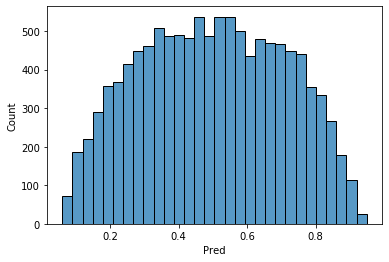

In [127]:
_ = sns.histplot(sub['Pred'])

In [128]:
sub.describe()

,Pred
count,11390.000000
mean,0.497025
std,0.210128
min,0.059860
25%,0.328778
50%,0.498537
75%,0.669647
max,0.949397


In [129]:
#train_df = df[df['Season']<2015][features]
#val_df = df[df['Season']==2015][features]
#train_results = df[df['Season']<2015]["WinA"]
#val_results = df[df['Season']==2015]["WinA"]

In [143]:
def kfold_knn(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[10:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        #df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "reg":
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = KNeighborsClassifier(n_neighbors=50)
            
        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred)
            plt.show()
        
        loss = log_loss(df_val['WinA'].values, pred)
        cvs.append(loss)

        if verbose:
            print(f'\t -> Scored {loss:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests

In [144]:
pred_tests = kfold_knn(df, test_df, plot=False, verbose=1, mode="cls")


Validating on season 2013
	 -> Scored 0.616

Validating on season 2014
	 -> Scored 0.597

Validating on season 2015
	 -> Scored 0.575

Validating on season 2016
	 -> Scored 0.582

Validating on season 2017
	 -> Scored 0.520

Validating on season 2018
	 -> Scored 0.610

Validating on season 2019
	 -> Scored 0.503

 Local CV is 0.572


In [145]:
sub = test_df[['ID', 'Pred']].copy()
sub['Pred'] = pred_test
sub.to_csv('submission.csv', index=False)

In [133]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scaled_train_df = scalar.fit_transform(train_df)
scaled_test_df = scalar.transform(val_df)

NameError: name 'train_df' is not defined

In [134]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [135]:
scaled_train_df

NameError: name 'scaled_train_df' is not defined

In [95]:
params = {'C': [0.001,0.01,0.1,1,10,100,1000]}
log_model = LogisticRegression(max_iter=10000)
grid_model = GridSearchCV(log_model,params)

In [96]:
grid_model.fit(scaled_train_df,train_results)

GridSearchCV(estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [97]:
grid_model.best_params_

{'C': 0.1}

In [98]:
pred = grid_model.predict(scaled_test_df)
pred_proba = grid_model.predict_proba(scaled_test_df)

In [99]:
from sklearn.metrics import confusion_matrix, classification_report, log_loss

In [100]:
print(confusion_matrix(val_results,pred))

[[50 17]
 [17 50]]


In [101]:
print(classification_report(val_results,pred))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        67
           1       0.75      0.75      0.75        67

    accuracy                           0.75       134
   macro avg       0.75      0.75      0.75       134
weighted avg       0.75      0.75      0.75       134



In [102]:
print(log_loss(val_results,pred_proba))


0.5208987801467613
